# Video Game Sales with Ratings 

Многие компании по созданию видеоигр перед выпуском очередной игры проводят некоторый анализ, чтобы предсказать будет игра успешной или нет.

С той же целью я рассмотрю таблицу, содержащую информацию о выпуске видеоигр на момент декабря 2016 года. На основании этих данных можно сделать выводы о необходимых изменениях или дополнениях в играх, для того чтобы они приносили наибольший доход. 

Таблица скачана с портала kaggle.com.

Для работы с указанной таблицей, импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize 
import eli5
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.metrics import classification_report, confusion_matrix
import lime
from lime.lime_tabular import LimeTabularExplainer
from causalinference import CausalModel

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Быстрый взгляд на данные

Рассматриваемый датасет имеет следующий вид и размер.

In [3]:
game = pd.read_csv("Video_Games.csv", sep=',') # прочитаем представленный датасет 
print(game.shape)
game.head()

(16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Удалим строки, которые содержат пустые ячейки, затем посмотрим на информацию о столбцах таблицы.

In [4]:
game = game.dropna()
game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
Name               6825 non-null object
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Other_Sales        6825 non-null float64
Global_Sales       6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null object
User_Count         6825 non-null float64
Developer          6825 non-null object
Rating             6825 non-null object
dtypes: float64(9), object(7)
memory usage: 906.4+ KB


- Name - название игры
- Platform - платформа, на которой выпущена игра
- Year_of_Release - год выпуска
- Genre -жанр
- Publisher - издатель
- NA_Sales - объем продаж игры в северной Америке (в миллиионах)
- EU_Sales - объем продаж игры в Европе (в миллиионах)
- JP_Sales - объем продаж игры в Японии (в миллиионах)
- Other_Sales - объем продаж игры в остальном мире, то есть в Африке, Азии (в миллионах единиц)
- Global_Sales - общий объем продаж в мире (в миллионах единиц)
- Critic_Score - совокупная оценка, поставленная сотрудниками Metacritic
- Critic_Count - количество критиков, которые участвовали при разработке Critic_score
- User_Score - оценка, поставленная подписчиками Metacritic
- User_Count - количество подписчиков, поставивших оценки
- Developer - разработчик игры
- Rating - рейтинг игры

## Шаги, кторые приводят к итоговой модели.

Что делает выпущенную игру успешной? - Объем вырученных средств. 

Поэтому будем считать, что игра стала успешной, если продажи по всему миру свыше 5 миллионов денежных едининиц.

 Создадим новый столбец, состоящий из 0 и 1, указывающий является ли игра успешной или нет.

In [5]:
def hit(x):
    if x >= 5:
        return 1
    else:
        return 0
game['Hit'] = game['Global_Sales']
game['Hit'] = game['Hit'].apply(lambda x: hit(x))

Далее удалим из таблицы столбцы, содержащие информацию об объемах продаж в разных частях мира.

In [6]:
game = game.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis = 1)

In [7]:
# Посмотрим сколько среди наших игр тех, что стали успешными.
game.Hit.value_counts()

0    6682
1     143
Name: Hit, dtype: int64

Как мы видим, безуспешных игр много больше нежели успешных.

Построим на несколько гистограм, которые показывают распределение количества безуспешных игр по типу платформы, жанру, разработчику и издателю.

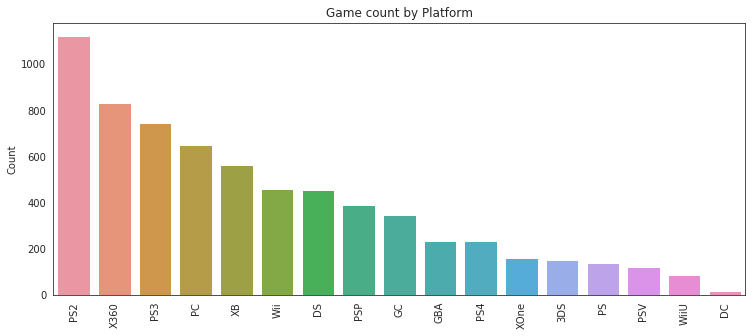

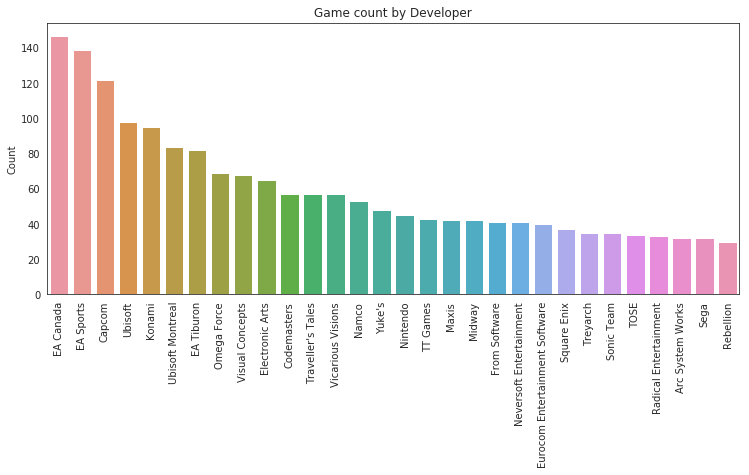

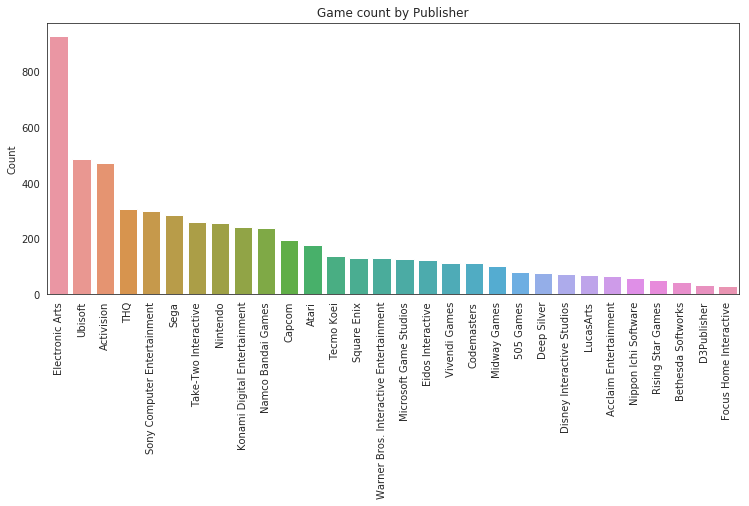

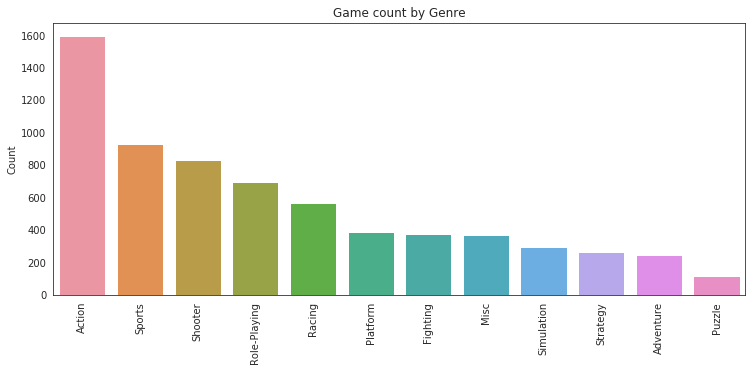

In [8]:
game1 = game[game['Hit'] == 0]
arr = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in arr:
    chart = game1[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30])
    plt.title('Game count by '+col)
    plt.ylabel('Count')
    plt.xlabel('')

На гистограммах видно, что почти треть всех безуспешных игр выпущено на платформу PS2, примерно 25% всех безуспешных игр в жанре экшн. К тому же видим, что существует несколько компаний-издателей и компаний-разработчиков, которые являются чаще остальные выпускают безуспешные игры.

Можем сделать вывод, что показатели 'Platform', 'Developer', 'Publisher' и 'Genre' имеют какое то влияение на успешность игры.

#### Рассмотрение взаимосвязей с помощью таблицы корреляций

Посмотрим на эти взаимосвязи более подробно. Построим нижнетреугольную таблицу корреляций.  Для этого изменим категориальные переменные на целые числа в соответствие их ндексам, чтобы можно было вычислить корреляции.

In [9]:
cols = ['Platform', 'Genre', 'Publisher']
copy = game.loc[:, ['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
for col in cols:
    uniques = copy[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        copy.loc[copy[col] == k, col] = v

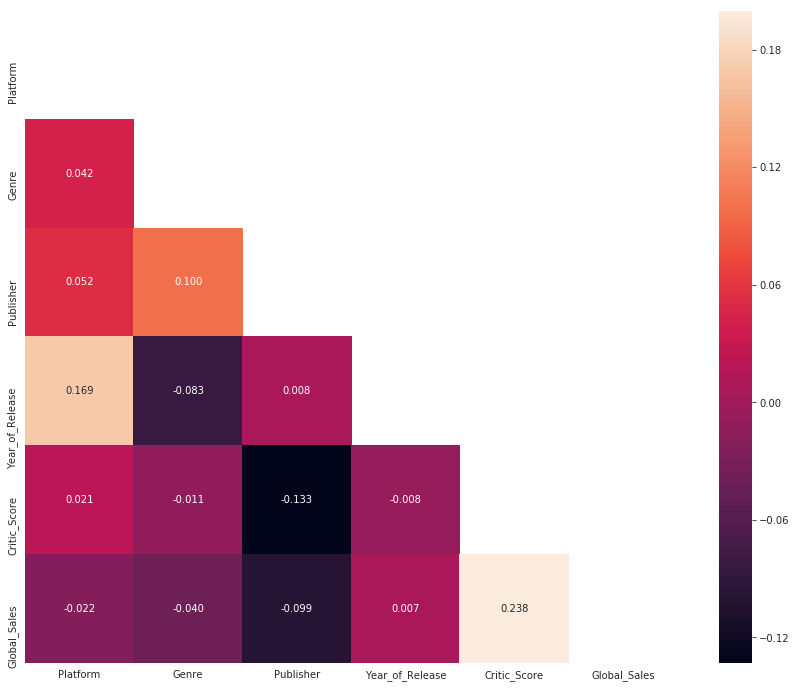

In [10]:
gam = copy[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
gam = gam.dropna().reset_index(drop=True)
gam = gam.astype('float64')
figsize(15, 12)
mask = np.zeros_like(gam.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(gam.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f")

Получим две явных взаимосвязи
- Год выпуска и тип платформы, что впринципе понятно. Обычно каждый год выпускается новый тип платформы.
- Оценка критиков и полученная выручка. Это уже очень интересно. 

Представляет интерес предсказать станет игра успешной или нет. Как видно из таблицы корреляций на успешность игры, то есть на объем полученной выручки, точно влияет оценка критиков. 

Какие еще показатели влияют на объем полученной выручки? Рассмотрим подробнее взаимосвязи в таблице.

#### Рассмотрение взаимосвязей с помощью CausalModel

In [11]:
game.Hit.value_counts()

0    6682
1     143
Name: Hit, dtype: int64

В наших данных количество безуспешных игр много больше, чем успешных. Для точности модели классификации проведем выравнивание данных методом Upsampling.

In [12]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = game[game.Hit==0]
df_minority = game[game.Hit==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6682,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
game_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
game_upsampled.Hit.value_counts()

1    6682
0    6682
Name: Hit, dtype: int64

In [13]:
# Получили таблицу game_upsampled, размер которой составляет
game_upsampled.shape

(13364, 13)

Посмотрим на взаимосвязь переменных Platform, Genre, age и Critic_Score на столбец Hit.

Для этого сначала, так же как и в начале отчета, переведем категориальные признаки типа string из таблицы game_upsampled в целые числа.

In [14]:
cols = ['Platform', 'Genre', 'Publisher']
copy_upsampled = game_upsampled.loc[:, ['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales', 'age', 'Hit']]
for col in cols:
    uniques = copy_upsampled[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        copy_upsampled.loc[copy_upsampled[col] == k, col] = v

Исследуем связь между успешностью игры и оценкой критиков, с контролем по Platform, Genre и Year_of_Release.

In [15]:
causal = CausalModel(Y = copy_upsampled['Critic_Score'].values,
                     D = copy_upsampled['Hit'].values,
                     X = copy_upsampled[['Platform', 'Genre','Year_of_Release']].values)

In [16]:
causal.est_via_ols()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     16.446      0.199     82.631      0.000     16.056     16.836
           ATC     15.838      0.200     79.358      0.000     15.447     16.230
           ATT     17.053      0.204     83.558      0.000     16.653     17.453



In [17]:
causal.est_via_matching()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     16.446      0.199     82.631      0.000     16.056     16.836
           ATC     15.838      0.200     79.358      0.000     15.447     16.230
           ATT     17.053      0.204     83.558      0.000     16.653     17.453

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     16.855      0.382     44.117      0.000     16.106     17.604
           ATC     16.551      0.260     63.556      0.000     16.041     17.062
           ATT     17.159      0.637     26.931      0.000     15.910     18.408



Получили, что существует связь между успешностью игры и оценками критиков и в этом случае ATE = 16.446. Полученный результат статистически значим, что видно из построенного доверительного интервала. 

После мэтчинга на переменные Platform, Genre и Year_of_Release показатель ATE увеличивается, но все еще остается статистически значимым результатом.

Таким образом, гипотезу о том, что взаимосвязи между указанными показателями нет, мы отвергаем на уровне значимости 0.05, так как p-val < 0.05

Таким образом, получаем задачу классификации, в которой Hit - зависимая переменная, а Platform, Genre, Year_of_Release и Critic_Score - предикторы.

## Модель классификации.

#### Подготовка данных для построения модели

Интересно ркассматривать отдельную игру с признаком возраста, а не года выпуска, так как возраст дает более конкретную информацию.

In [18]:
game_upsampled = game_upsampled[game_upsampled["Year_of_Release"].notnull()]
game_upsampled = game_upsampled[game_upsampled["Genre"].notnull()]
game_upsampled["Year_of_Release"] = game_upsampled["Year_of_Release"].apply(int)

game_upsampled['age']=2018 - game_upsampled['Year_of_Release']

In [19]:
df = game_upsampled.drop(['Year_of_Release', 'Publisher', 
                          'Developer', 'Rating', 'Name', 'Global_Sales', 
                          'Critic_Count', 'User_Score', 'User_Count'], axis = 1)
df.head() 

,Platform,Genre,Critic_Score,Hit,age
208,PS2,Misc,82.0,0,11
209,Wii,Shooter,68.0,0,11
211,X360,Role-Playing,93.0,0,10
212,PS3,Action,88.0,0,11
213,PS2,Sports,88.0,0,13


#### Построение модели

В качестве модели классификации выберем DecisionTreeClassifier. Были построены следующие модели: Логистическая регрессия, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier. 
Выбор пал именно на модель RandomForestClassifier, так как она дает наиболее точный и хороший результат. 

In [20]:
df_copy = pd.get_dummies(df) # one-hot encoding
cols = list(df_copy)

X = df_copy.drop(['Hit'], axis = 1) # предикторы
y = df_copy['Hit'] # зависимая переменная
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/4) # разбили на тестовую и обучающую выборки

In [21]:
tree = RandomForestClassifier(n_estimators=100)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print('R^2 = ' + str(tree.score(X_train, y_train)))

R^2 = 0.9987029831387808


Посмотрим на метрики качества классификатора и построим матрицу ошибок.

In [22]:
print(classification_report(y_test,pred_tree))
print()
print(confusion_matrix(y_test,pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1662
           1       0.98      1.00      0.99      1679

   micro avg       0.99      0.99      0.99      3341
   macro avg       0.99      0.99      0.99      3341
weighted avg       0.99      0.99      0.99      3341


[[1633   29]
 [   0 1679]]


Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, в нашем случае данная метрика показывает, что предсказание очень точное.

Precision показывает способность отличать данный класс от других классов, в нашем случае данная мера показывает, что построенный классификатор отличает оба класса друг от друга почти на 100%.

## Интерпритация модели

#### Проведем исследование того, какие переменные оказывают наибольшее влияние на модель.

In [23]:
names = list(df_copy)
names.remove('Hit')

In [24]:
eli5.show_weights(tree, feature_names=names)

Weight,Feature
0.5255 ± 0.0570,Critic_Score
0.1415 ± 0.0453,age
0.0296 ± 0.0294,Genre_Misc
0.0264 ± 0.0246,Platform_Wii
0.0220 ± 0.0186,Genre_Sports
0.0213 ± 0.0111,Platform_PC
0.0202 ± 0.0156,Platform_XB
0.0199 ± 0.0162,Genre_Shooter
0.0194 ± 0.0147,Genre_Action
0.0146 ± 0.0113,Genre_Role-Playing


Как мы видим наиболее важными для классификатора являются следующие признаки:
   - Critic_Score - это можно просто объяснить. Чтобы преобрести ту или иную видеоигру, каждый человек основывается на ее отзывах и оценках. 
   - Age. Возраст игры очень важен при ее покупке, так как мы живем во время современных технологий, где все развивается достаточно быстро. Если игра достаточно давно выпущена, то велика вероятность, что на рынке есть более популярная игра, подходящая для более новых моделей различных платформ. Соответственно чем старее игра, тем менее вероятна ее покупка.
   - Genre. Все люди разные, все предпочитают разное. Кто-то предпочиатет один жанр, кто-то совсем другой. Как видно из таблицы, есть несколько наиболее популярных жанров, которые влияют на успешность игры.

#### Проведем исследование предсказания на конкретном примере.

In [25]:
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names, 
                                 discretize_continuous=False) 

In [26]:
exp = explainer.explain_instance(X_test.iloc[34,:], 
                                 tree.predict_proba)

In [27]:
exp.show_in_notebook();

Для первых десяти наиболее значимых предикторов построили график показывающих долю, который каждый из них вкладывает.

То есть, увеличивая оценку критиков на 1, вероятность предсказания успешной игры увеличивается на 16%. 

## Вывод 

Таким образом получаем, что успешность игры почти напрямую зависит от оценки критиков. 

Если критики сказали что игра хорошая, следовательно, успешность ей гарантирована.